#### Part 1. 
Time cohorts: Clientes que se inscribieron en un producto servicio durante un periodo de tiempo determinado. Con esto se puede estudiar el comportamieto desde que adquieron el producto en un tiempo.
Behavior cohorts: Estudio de los clientes que adquirieron un producto en el pasado y se agrupa por dicha suscripcion 
Size cohorts: Estudio de los diversos tamaños de clientes que comprar los productos de una empresa puede basarse en la cantidad de gasto en un tiempo.

Los valores en esta tabla muestran las personas activas o que adquirieron un determinado servicio con respecto a una fecha.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

data = pd.read_csv('online.csv')
df = pd.DataFrame(data)
df.head(5)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [3]:
## Pasamos de tipo object a tipo datatime con el formato requerido
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d')

Segmentaresmos los clientes en grupos de adquisicion basados en el mes en que hicieron su primera compra. Luego se asignara el indice de cohorte a cada compra del cliente. Esto representara el numero de meses desde la primera transaccion.

In [4]:
## Le damos formato a la fecha de facturacion tomando el primer dia de dicho mes
def get_month(x): return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

## Como el cliente a facturado varios meses lo agrupamos con respecto a las fechas que tenga y creamos una columna que contenga
## la fecha menor para lograr saber cuando realizo la subscripcion

group = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = group.transform('min')
df.head(5)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01


In [5]:
## Calculamos el desplazamiento del tiempo 1. funcion que toma los valores y los transforma a entero
def get_date_int (df,column):
    año = df[column].dt.year
    mes = df[column].dt.month
    dia = df[column].dt.day
    return año,mes,dia

In [6]:
## Calculamos el desplazamieto en el tiempo para las columnas
invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth' )
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

## Se obtiene la diferencia en los meses y años
dif_año = invoice_year-cohort_year
dif_mes = invoice_month-cohort_month

## Se crea la columna con los datos respectivamente
df['CohortIndex'] = dif_año * 12 + dif_mes + 1 ## + 1 para que tome el mes como 1 y no 0
df.head(5)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,1
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,4


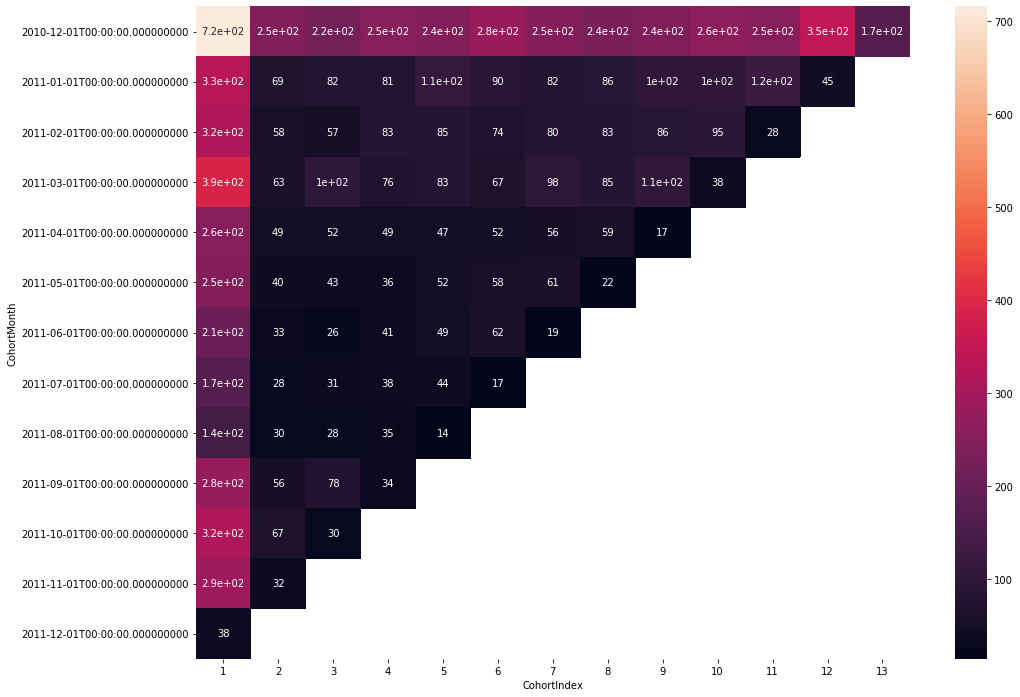

In [7]:
## Ahora se calcula la cantidad de clientes activos por mes
## 1.Agrupamos que tengan misma fecha de inicio y misma duracion en la subscripcion
group = df.groupby(['CohortMonth','CohortIndex'])
## 2.Tomamos los objetos unicos dentro de las ID 
cohort_data = group['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

## Creamos la tabla 
cohort_counts = cohort_data.pivot(index='CohortMonth', 
                                  columns='CohortIndex', 
                                  values='CustomerID')

## Observamos la tabla
plt.figure(figsize=(16,12))
sns.heatmap(cohort_counts, annot=True)
plt.show()

In [8]:
print(cohort_counts)

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   716.0  246.0  221.0  251.0  245.0  285.0  249.0  236.0  240.0   
2011-01-01   332.0   69.0   82.0   81.0  110.0   90.0   82.0   86.0  104.0   
2011-02-01   316.0   58.0   57.0   83.0   85.0   74.0   80.0   83.0   86.0   
2011-03-01   388.0   63.0  100.0   76.0   83.0   67.0   98.0   85.0  107.0   
2011-04-01   255.0   49.0   52.0   49.0   47.0   52.0   56.0   59.0   17.0   
2011-05-01   249.0   40.0   43.0   36.0   52.0   58.0   61.0   22.0    NaN   
2011-06-01   207.0   33.0   26.0   41.0   49.0   62.0   19.0    NaN    NaN   
2011-07-01   173.0   28.0   31.0   38.0   44.0   17.0    NaN    NaN    NaN   
2011-08-01   139.0   30.0   28.0   35.0   14.0    NaN    NaN    NaN    NaN   
2011-09-01   279.0   56.0   78.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   318.0   67.0   30.0    NaN    NaN    NaN    NaN    

In [9]:
## METRICAS
## 1.Retencion: Mide cuantos clientes de cada cohort ha vuelto en los meses siguientes
## Tomamos la cantidad de clientes que se inscribieron en cada mes - cohort
Cohort_1mes = cohort_counts.iloc[:,0]
## Calculamos el procentaje de personas que duraron en los meses siguientes: Axis= 0 porque es con respecto a las filas
retencion = cohort_counts.divide(Cohort_1mes, axis=0) # .round(3)*100

Podemos observar que para el primer mes de cada grupo de fecha su retencion fue de 100 dado que fueron activos en su primer mes de subscripcion. Para el cohort 2010-12-01 vemos una retencion del 34% para 2 meses.

In [10]:
print(retencion)

CohortIndex   1         2         3         4         5         6         7   \
CohortMonth                                                                    
2010-12-01   1.0  0.343575  0.308659  0.350559  0.342179  0.398045  0.347765   
2011-01-01   1.0  0.207831  0.246988  0.243976  0.331325  0.271084  0.246988   
2011-02-01   1.0  0.183544  0.180380  0.262658  0.268987  0.234177  0.253165   
2011-03-01   1.0  0.162371  0.257732  0.195876  0.213918  0.172680  0.252577   
2011-04-01   1.0  0.192157  0.203922  0.192157  0.184314  0.203922  0.219608   
2011-05-01   1.0  0.160643  0.172691  0.144578  0.208835  0.232932  0.244980   
2011-06-01   1.0  0.159420  0.125604  0.198068  0.236715  0.299517  0.091787   
2011-07-01   1.0  0.161850  0.179191  0.219653  0.254335  0.098266       NaN   
2011-08-01   1.0  0.215827  0.201439  0.251799  0.100719       NaN       NaN   
2011-09-01   1.0  0.200717  0.279570  0.121864       NaN       NaN       NaN   
2011-10-01   1.0  0.210692  0.094340    

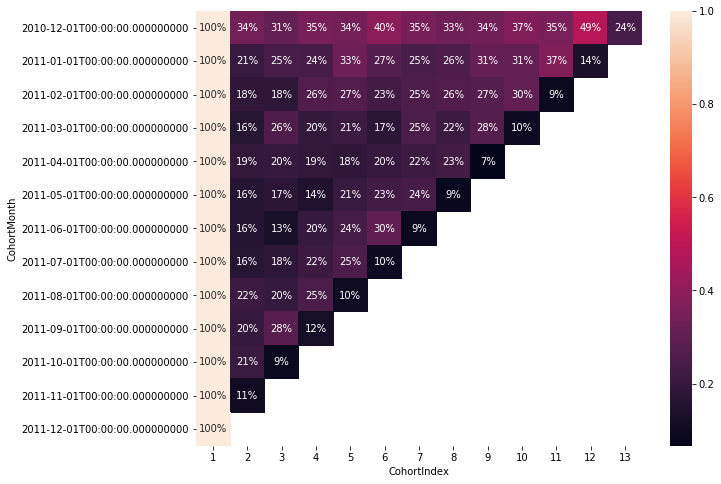

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(retencion, annot=True, fmt='.0%')
plt.show()

#### SEGMENTACION RFM
1. Calculo de Recency : Cuan frecuente fue la ultima compra de cada cliente
2. Frecuencia: Cuantas compras ha hecho el cliente en los ultimos 12 meses
3. Monetary Value: Cuanto ha gastado en los ultimos 12 meses

#### Part 2.
Tabla RFM preprocesada y ajustada para segmentacion

In [12]:
data_rfm = pd.read_csv('rfm_datamart.csv')
rfm = pd.DataFrame(data_rfm)
rfm

,CustomerID,Recency,Frequency,MonetaryValue
0,12747,3,25,948.70
1,12748,1,888,7046.16
2,12749,4,37,813.45
3,12820,4,17,268.02
4,12822,71,9,146.15
...,...,...,...,...
3638,18280,278,2,38.70
3639,18281,181,2,31.80
3640,18282,8,2,30.70
3641,18283,4,152,432.93


Preprocesamiento:

In [13]:
rfm.skew() ## Demasiado sesgo

CustomerID       -0.006103
Recency           1.194433
Frequency        18.015551
MonetaryValue    20.469911
dtype: float64

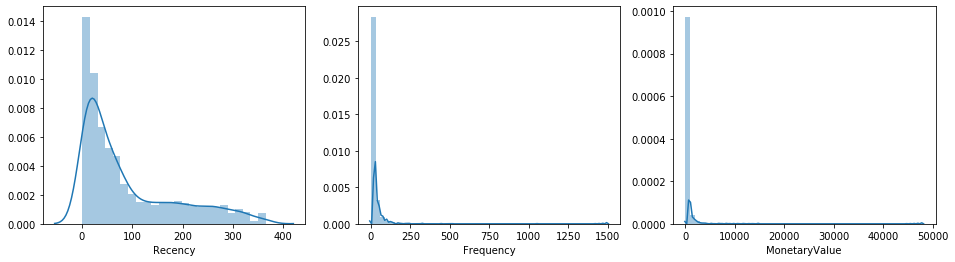

In [14]:
#PRIMERA VISTA
columns = rfm[['Recency','Frequency','MonetaryValue']].columns

fig, axes = plt.subplots(ncols=3, nrows=1,figsize=(16,4))
for col, axes in zip(columns, axes.flatten()):
    sns.distplot(rfm[col], ax=axes)

In [15]:
#CORRECCION DE SESGOS Y ESTANDARIZACION
from sklearn.preprocessing import PowerTransformer
sca_sk = PowerTransformer(method='yeo-johnson', standardize=True)
rfm[columns] = sca_sk.fit_transform(rfm[columns])

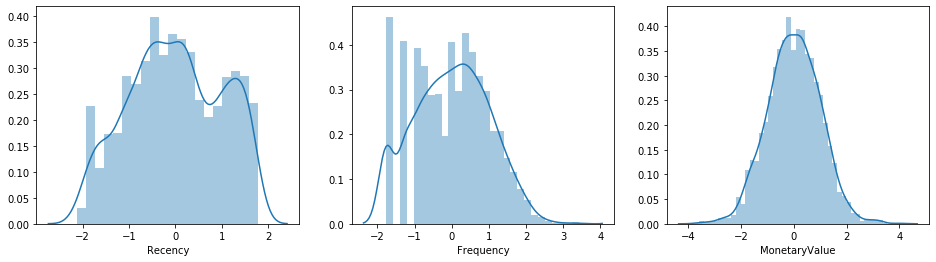

In [16]:
## DESPUES DE LA TRANSFORMACION
fig, axes = plt.subplots(ncols=3, nrows=1,figsize=(16,4))
for col, axes in zip(columns, axes.flatten()):
    sns.distplot(rfm[col], ax=axes)

##### K-means

In [17]:
rfm = rfm.drop('CustomerID', axis='columns')

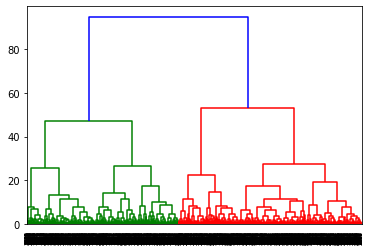

In [66]:
#Dendograma
import scipy.cluster.hierarchy as sch
dedogram = sch.dendrogram(sch.linkage(rfm, method='ward'))

Clusters = 2 Media silhouette_score: 0.3936636249739556
Clusters = 3 Media silhouette_score: 0.3006151493813695


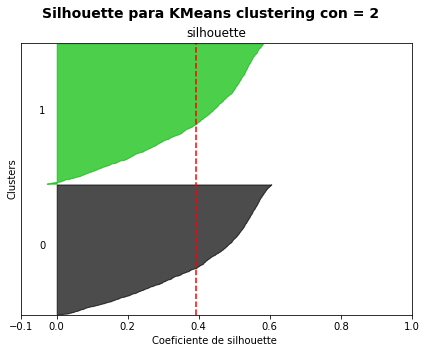

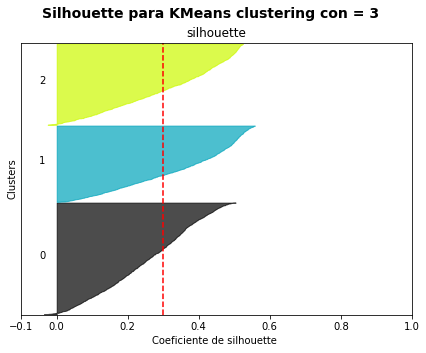

In [67]:
# TEST silhouette
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(7, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(rfm) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, max_iter=500, random_state=5)  
    cluster_labels = clusterer.fit_predict(rfm)

    silhouette_avg = silhouette_score(rfm, cluster_labels)
    print("Clusters =", n_clusters,
          "Media silhouette_score:", silhouette_avg)

    sample_silhouette_values = silhouette_samples(rfm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)


        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("silhouette")
    ax1.set_xlabel("Coeficiente de silhouette ")
    ax1.set_ylabel("Clusters")

   
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    
    plt.suptitle(("Silhouette para KMeans clustering con = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

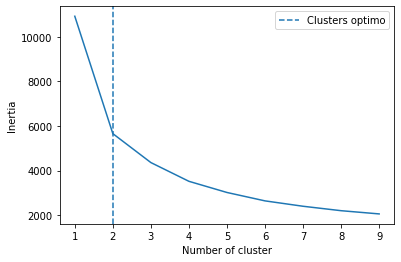

In [68]:
## INERTIA
from sklearn.cluster import KMeans

inertia = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(rfm)
    inertia[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.axvline(x=2, label='Clusters optimo', linestyle='--')
plt.legend()
plt.show()

In [18]:
#VIENDO EL OPTIMO PARA 2 CLUSTERS
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2)
model.fit(rfm)

KMeans(n_clusters=2)

In [19]:
#SEGMENTACION PARA POSIBLE RENOVACION DE SUSCRIPCION 
rfm['labels'] = model.labels_
rfm.head(5)

,Recency,Frequency,MonetaryValue,labels
0,-1.750517,0.902087,1.451388,1
1,-2.121134,3.193234,2.838394,1
2,-1.623314,1.212956,1.340401,1
3,-1.623314,0.582787,0.519611,1
4,0.250442,0.032808,0.056997,0


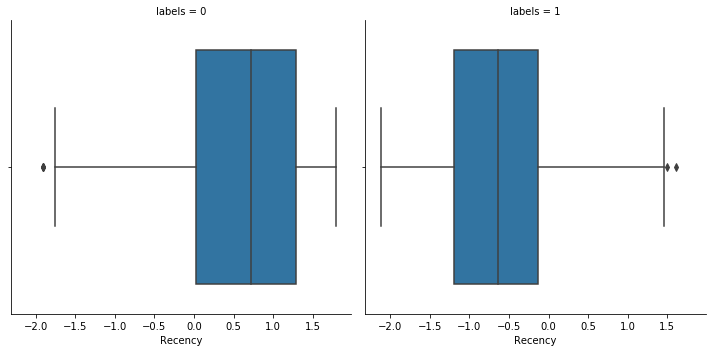

In [27]:
#SEGMENTACION RECENCY
sns.catplot(x='Recency', col='labels', data=rfm, kind='box')
plt.show()

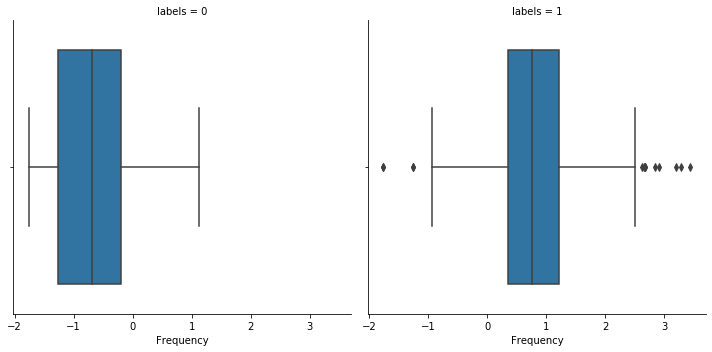

In [23]:
#SEGMENTACION FREQUENCY
sns.catplot(x='Frequency', col='labels', data=rfm, kind='box')
plt.show()

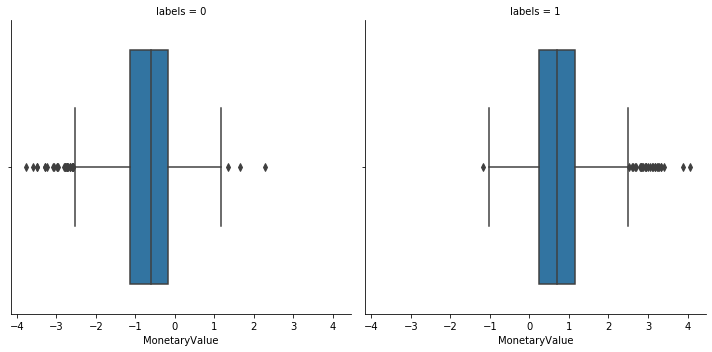

In [24]:
#SEGMENTACION MONETARYVALUE
sns.catplot(x='MonetaryValue', col='labels', data=rfm, kind='box')
plt.show()

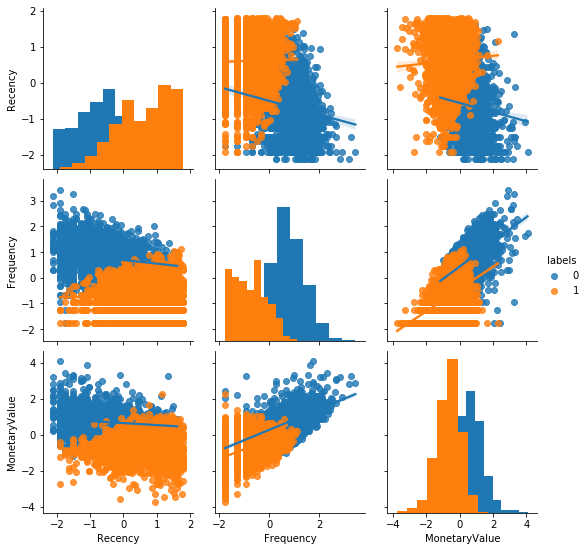

In [74]:
#RELACION DE LOS LABELS CON LOS DATOS OBTENIDOS
sns.pairplot(rfm, kind='reg', diag_kind='hist', hue='labels')
plt.show()

#### Analisis segmentacion
Dado la segmentacion por medio de Kmeans podemos observar que la agrupacion para 0 y 1 se obtiene:

Label 1: Dentro de este grupo pertenecen las personas que han comprado productos de una manera frecuente dentro de los ultimos 12 meses al igual que su gasto monetario alto para dichas compras.

Label 0. Agrupacion para personas con baja frecuencia de compra, bajo consumo monetario